# Image preparation

Загрузка fits-изображений с Legacy, подгонка size (на данный момент (31 июля 2022) не использовалась из-за большого кол-ва времени загрузки изображений, кадры обрезались после поворота), поворот, обрезка, рисование изофот (некоторые проблемы, а именно: как всё-таки лучше задавать интервалы), цвета.

Два режима: автоматический и интерактивный (в случае, если автоматический не справится).
В первом режиме на вход подаётся список имён галактик, которые есть в voting_with_coords.csv. Во втором режиме либо указывается имя галактики и имя списка, из которого галактика взята, например, iso_break.

Здесь также есть некоторые заметки по example_pipeline.ipynb.

In [245]:
%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


/home/vallastro/Serverspace/Serverspace/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['draw', 'size', 'convolve']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Необходимо выбрать режим: a - автоматический, i - интерактивный

In [246]:
mode = 'a'

Список ВСЕХ галактик (на данный момент это voting_with_coords.csv), он должен быть в папке data

In [247]:
file_all_gal = 'voting_with_coords.csv'

Список галактик для обработки (тоже в data)

In [248]:
file_proc_gal = 'bad_cases.csv'

# Load pandas data

In [249]:
import pandas as pd

In [250]:
df_all_gal = pd.read_csv('../data/{}'.format(file_all_gal), header=None)  # Общий df всех имеющихся галактик
df_proc_gal = pd.read_csv('../data/{}'.format(file_proc_gal), header=None) 

# Legacy fits loading and frame size adjustment

https://www.legacysurvey.org/viewer. 
Загружаются fits-файлы. Подгонка основывается на https://photutils.readthedocs.io/en/stable/segmentation.html. То есть получаются параметры, по которым можно преобразовать кадр. Достаточно применить один раз (то есть один раз получаются параметры описывающего эллипса), поэтому подгонка применяется к исходному (не к модели, не к вычету) изображению в полосе z.

In [251]:
import numpy as np
import os
import urllib

from astropy.io import fits as pyfits # у меня почему-то не сработало import pyfits
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources, SourceFinder, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve

In [252]:
# Загрузка изображений (исходные (raw), модели (model), вычеты (residual))
def geturl_legacy(ra, dec, size=240, band='z', layer='ls-dr9'): # для перехода от dr8 к dr9n нужно было
                                                                      # добавить ls-
    assert band in ['g', 'r', 'z']
    assert layer in ['ls-dr9', 'ls-dr9-model', 'ls-dr9-resid']

    url = ("http://legacysurvey.org/viewer/cutout.fits?ra={}&dec={}&layer={}&pixscale=0.27&bands={}&size={}").format(ra, dec, layer, band, size)
    return url           # здесь вместо fits-cutout/? нужно было cutout.fits?

def clear_on_fail_(name, dir_path):
    for layer in ['ls-dr9', 'ls-dr9-resid', 'ls-dr9-model']:
        for band in ['g', 'r', 'z']:        
            output_image='{}/{}_{}_{}.fits'.format(dir_path, name, layer, band)
            try:
                os.remove(output_image)
            except:
                pass
# Основная функция. Здесь ещё все папки создаются
def load_legacy(name_fold=None,name=None, ra=None, dec=None, size=None):
    if not os.path.isdir('../data/images/{}'.format(name_fold)):
            os.makedirs('../data/images/{}'.format(name_fold))
    if not os.path.isdir('../data/images/{}/{}'.format(name_fold,name)):
            os.makedirs('../data/images/{}/{}'.format(name_fold,name))
    if not os.path.isdir('../data/images/{}/{}/fits'.format(name_fold,name)):
            os.makedirs('../data/images/{}/{}/fits'.format(name_fold,name))
    if not os.path.isdir('../data/images/{}/{}/png'.format(name_fold,name)):
            os.makedirs('../data/images/{}/{}/png'.format(name_fold,name))
    i = 0
    for layer in ['ls-dr9', 'ls-dr9-model', 'ls-dr9-resid']:
        lay_save = ['raw','model','residual']       
        save_to='../data/images/{}/{}/fits/{}'.format(name_fold,name,lay_save[i])
        dir_png='../data/images/{}/{}/png/{}'.format(name_fold,name,lay_save[i])
        i += 1
        if not os.path.isdir(save_to):
            os.mkdir(save_to)
        if not os.path.isdir(dir_png):
            os.mkdir(dir_png)
        for band in ['g', 'r', 'z']:
            try:
                fitsurl = geturl_legacy(ra, dec, band=band, size=size, layer=layer)             
                output_image='{}/{}_{}_{}.fits'.format(save_to, name, layer, band)
                if os.path.exists(output_image):
                    continue
                urllib.request.urlretrieve(fitsurl, output_image)
                if os.path.getsize(output_image)/1024 < 3:  # empirical threshold
                    clear_on_fail_(name, save_to)
                    break;break
            except Exception as e:
                clear_on_fail_(name, save_to)
                raise e  

In [253]:
# Получаем индекс галактики в voting_with_coords.csv, чтоб по индексу можно было получить ra,dec
def getind_gal(name_gal,df):
    for i in arange(1,df.shape[0]):
        if name_gal == df[0][i]:
            return i 
            break        

In [254]:
# Рисуем непреобразованные изображения, такие, какие изначально с Legacy 
def draw(name_fold,name_gal):
    i = 0
    for layer in ['ls-dr9', 'ls-dr9-model', 'ls-dr9-resid']:
        lay_save = ['raw','model','residual']
        for band in ['g', 'r', 'z']:
            pathfits = '../data/images/{}/{}/fits/{}/{}_{}_{}.fits'.format(name_fold,name_gal,
                                                                                      lay_save[i],name_gal,layer,band)
            pathpng = '../data/images/{}/{}/png/{}/{}_{}_{}.png'.format(name_fold,name_gal,
                                                                                      lay_save[i],name_gal,layer,band)
            hdulist = pyfits.open(pathfits)
            img_header = hdulist[0].header
            img_data_raw = hdulist[0].data
            
            fig = plt.figure(figsize=[10,10])
            plt.subplot(111)
            plt.imshow(img_data_raw, vmin=0, vmax=0.3)
            plt.savefig(pathpng)
        i += 1

In [267]:
# Получаем параметры описывающего галактику эллипса, чтобы потом повернуть на нужный угол и обрезать
def getparams_ell(name_fold,name_gal,segdeb_npix,segdeb_nlev,segdeb_contr):    
    pathimag_z='../data/images/{}/{}/fits/raw/{}_ls-dr9_z.fits'.format(name_fold,name_gal,name_gal)
    pathparams='../data/images/{}/{}/fits/raw/{}_ls-dr9_z_params.dat'.format(name_fold,name_gal,name_gal)
    pathpng = '../data/images/{}/{}/png/raw/{}_segments.png'.format(name_fold,name_gal,name_gal)
    
    hdulist = pyfits.open(pathimag_z)
    img_header = hdulist[0].header
    img_data_raw = hdulist[0].data
    
    bkg_estimator = MedianBackground()
    bkg = Background2D(img_data_raw, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
    img_data_raw -= bkg.background  # subtract the background
    
    threshold = 1.5 * bkg.background_rms
    
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.
    convolved_data = convolve(img_data_raw, kernel)
    segment_map = detect_sources(convolved_data, threshold, npixels=10)
    
    segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=segdeb_npix, nlevels=segdeb_nlev, contrast=segdeb_contr,
                               progress_bar=False)
    
    cat = SourceCatalog(img_data_raw, segm_deblend, convolved_data=convolved_data)
    tab = cat.to_table()
    
    #Предполагается, что наша галактика по видимой площади самая большая, поэтому нужно узнать индекс этой
    # наибольшей площади, чтобы потом сделать вырезку (выделить строку) из таблицы, которая содержит параметры
    # всех обнаруженных источников, а нам нужен только один источник - исследуемая галактика.
    ColLab = tab['label']
    MaxColLab = ColLab[-1]
    ColArea = tab['area']
    ColArea0 = ColArea.copy() 
    ColArea.sort()
    MaxArea = ColArea[-1]
    for i in arange(MaxColLab):
        if ColArea0[i] == MaxArea:
            MaxAreaIndex = i+1
    
    catsub = cat.get_label(MaxAreaIndex)
    tabsub = catsub.to_table() # По сути, это строчка параметров нашей исследуемой галактики
    
    # Делаем рисунок со всеми овалами/кружками и описанными эллипсами/окружностями
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,
           interpolation='nearest')
    cat.plot_kron_apertures(axes=ax, color='white', lw=1.5)
    ax.invert_yaxis()
    plt.savefig(pathpng)
    if mode == 'i':
        plt.show()    
    return tabsub

In [256]:
# Получаем новые размеры кадра. newsize - предполагалось, что будет повторная загрузка изображений с этим уже
# новым size, но т.к. загрузка занимает очень много времени, был оставлен исходный размер size; 
# sizefac - множитель, чтобы галактика не была впритык к границам кадрам, xfac,yfac - множители, чтобы 
# в обрезанном после поворота кадре галактика не была впритык к границам. 
def getnew_cropsize(input_tab,sizefac,xfac,yfac):
    area = input_tab['area'].value
    ecc = input_tab['eccentricity'].value
    xcentroid = input_tab['xcentroid'].value
    ycentroid = input_tab['ycentroid'].value
    simimaj = np.sqrt(area/(np.pi*np.sqrt(1.0-ecc**2)))
    simimin = simimaj*np.sqrt(1.0-ecc**2) 
    
    newsize = 2.0*simimaj*sizefac
    xcropsize = simimaj*xfac
    ycropsize = simimin*yfac
    
    return [newsize,xcropsize,ycropsize,xcentroid,ycentroid]

# Rotate and crop the frame

In [257]:
from scipy.ndimage import rotate
from astropy.visualization import ZScaleInterval, PercentileInterval

In [258]:
# Поворот и обрезка кадра
def rotate_crop_image(name_fold,name_gal,angle,size,xlen,ylen,xcentroid,ycentroid):
    i = 0
    for layer in ['ls-dr9', 'ls-dr9-model', 'ls-dr9-resid']:
        lay_save = ['raw','model','residual']
        for band in ['g', 'r', 'z']:
            pathfits = '../data/images/{}/{}/fits/{}/{}_{}_{}.fits'.format(name_fold,name_gal,
                                                                                      lay_save[i],name_gal,layer,band)
            pathrotcropfits='../data/images/{}/{}/fits/{}/{}_{}_{}_rotcrop.fits'.format(name_fold,name_gal,
                                                                                      lay_save[i],name_gal,layer,band)
            pathpng = '../data/images/{}/{}/png/{}/{}_{}_{}_rotcrop.png'.format(name_fold,name_gal,
                                                                                      lay_save[i],name_gal,layer,band)
            hdulist = pyfits.open(pathfits)
            img_header = hdulist[0].header
            img_data_raw = hdulist[0].data
            
            rot_im = rotate(img_data_raw, angle=angle[0], reshape=False)
            
            xcen = size / 2.0
            ycen = size / 2.0
            xcenrot = (xcentroid - xcen) * np.cos(angle[0]) - (ycentroid - ycen) * np.sin(angle[0]) + xcen
            ycenrot = (xcentroid - xcen) * np.sin(angle[0]) + (ycentroid - ycen) * np.cos(angle[0]) + ycen
            
            ymin = max(0, int(ycenrot-ylen))
            ymax = min(size, int(ycenrot+ylen))
            xmin = max(0, int(xcenrot-xlen))
            xmax = min(size, int(xcenrot+xlen))
            rot_im = rot_im[ymin:ymax, xmin:xmax] 
            
            hdu = pyfits.PrimaryHDU(data=rot_im) 
            hdu.writeto(pathrotcropfits,overwrite=True)
            
            fig = plt.figure(figsize=[11,6])
            ax = plt.gca()
            plt.subplot(111)
            plt.imshow(rot_im, vmin=0, vmax=1.2)
            plt.savefig(pathpng)
            if band == 'z':
                if layer == 'ls-dr9':
                    if mode == 'i':
                        ax.grid()
                        #ax.axhline(y=207)
                        #ax.axhline(y=196)
                        plt.show()
        i += 1

# Isophotes and color index g-r

In [259]:
# Рисуются изофоты. Пожалуй, пока самая проблемная часть, т.к. пока непонятен оптимальный вариант регулирования
# контурами и диапазона значений. Пока что лучше вручную этим заниматься
def draw_iso(name_fold,name_gal,size):
    i = 0
    for layer in ['ls-dr9', 'ls-dr9-resid']:
        lay_save = ['raw','residual']
        for band in ['g', 'r', 'z']:
            pathfits = '../data/images/{}/{}/fits/{}/{}_{}_{}_rotcrop.fits'.format(name_fold,name_gal,
                                                                                      lay_save[i],name_gal,layer,band)
            pathpng = '../data/images/{}/{}/png/{}/{}_{}_{}_rotcropiso.png'.format(name_fold,name_gal,
                                                                                      lay_save[i],name_gal,layer,band)
            hdulist = pyfits.open(pathfits)
            img_header = hdulist[0].header
            img_data_raw = hdulist[0].data
            
            xmin = int(size/2.0 - size/3.0)
            xmax = int(size/2.0 + size/3.0)
            
            lim2 = np.max(img_data_raw)
            lim1 = lim2 / 100
            
            fig = plt.figure(figsize=[18,9])
            ax = fig.add_subplot(1, 1, 1)      # А вот и контуры. Как это всё контролировать. Возможно, что-то
                                              # ещё можно вынести в параметры функции. Возможно, нужен дополнительный
                                                                  # алгоритм, чтобы уверенно определялись уровни
            ax.imshow(np.log2(img_data_raw), cmap=cm.bone_r, vmin=-6, vmax=-0.5)
            ax.contour(np.log2(img_data_raw), levels=np.linspace(np.log2(lim1), np.log2(lim2), 11), colors='m', 
                                                    linestyles='solid', linewidths=1.0, alpha=0.8)
            plt.savefig(pathpng) 
        i += 1

In [260]:
# Показатель цвета g-r
def draw_color(name_fold,name_gal):
    i = 0
    for layer in ['ls-dr9', 'ls-dr9-resid']:
        lay_save = ['raw','residual']            
        pats_g = '../data/images/{}/{}/fits/{}/{}_{}_g_rotcrop.fits'.format(name_fold,name_gal,
                                                                            lay_save[i],name_gal,layer)
        path_r = '../data/images/{}/{}/fits/{}/{}_{}_r_rotcrop.fits'.format(name_fold,name_gal,
                                                                            lay_save[i],name_gal,layer)
        pathpng = '../data/images/{}/{}/png/{}/{}_{}_gr_rotcropcolor.png'.format(name_fold,name_gal,
                                                                            lay_save[i],name_gal,layer)
        hdulist = pyfits.open(pats_g)
        data = hdulist[0].data
        data_g = 22.5 - 2.5*np.log10(data)

        hdulist = pyfits.open(path_r)
        data = hdulist[0].data
        data_r = 22.5 - 2.5*np.log10(data)

        magcolour = data_g - data_r
        
        fig = plt.figure(figsize=[18,9])
        ax = plt.gca()                     # Рисуется здесь попроще, но всё равно нужно подумать
        im=plt.imshow(magcolour, cmap=cm.hot_r, vmin=-1, vmax=1.5)
        fig.colorbar(im, orientation='horizontal')
        # ax.contour(magcolour[::-1,:], levels=np.linspace(0.8, 0.9, 3), colors='g', alpha=0.6)
        ax.contour(magcolour, levels=np.linspace(0.9, 1.7, 5), colors='b', alpha=0.6)
        # ax.contour(magcolour[::-1,:], levels=np.linspace(0.005, 0.05, 5), colors='g', alpha=0.6)
        plt.savefig(pathpng)
        i += 1

# ============================================
#                     Run
# ============================================
Перед запуском не забыть в самом начале указать список галактик и загрузить соответствующий pandas data. Ну и нужный режим поставить

#  Auto mode
--------------------------

Здесь везде mode=='a' (потом и mode=='i'). Возможно, это не так и нужно, но чтобы случайно не начало выполнятся при случайном нажатии на запуск.

In [262]:
# Общее для всего режима
if mode=='a':
    name_fold = file_proc_gal.replace('.csv',"")

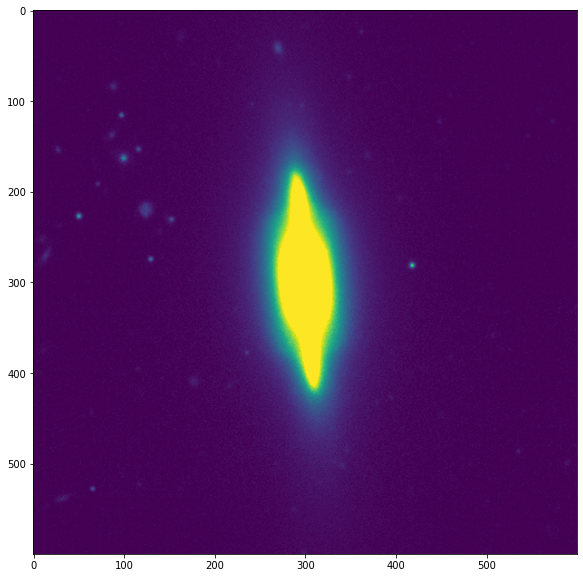

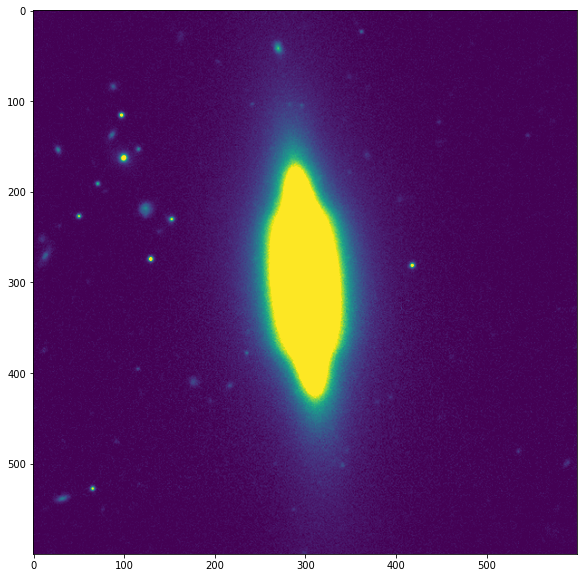

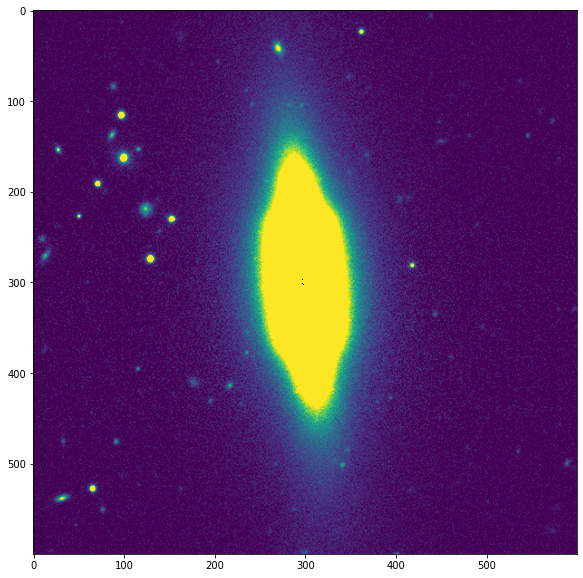

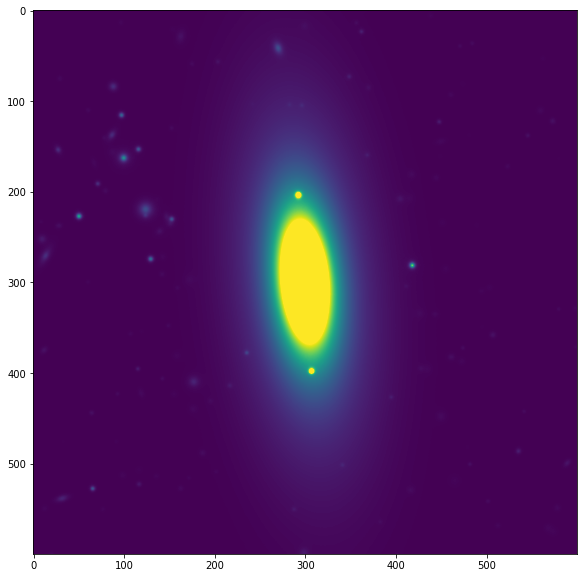

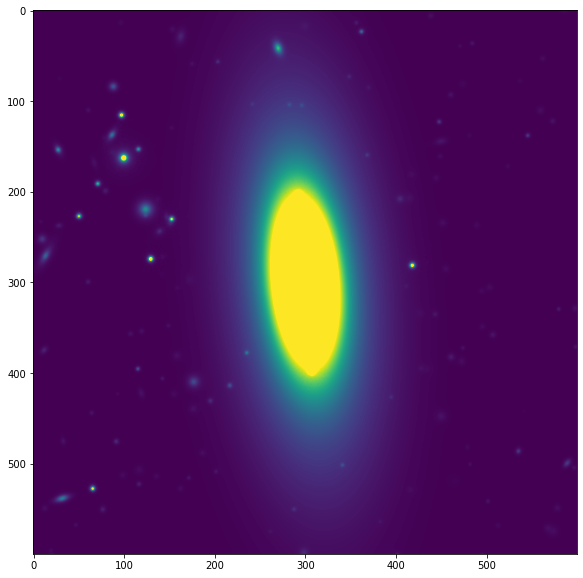

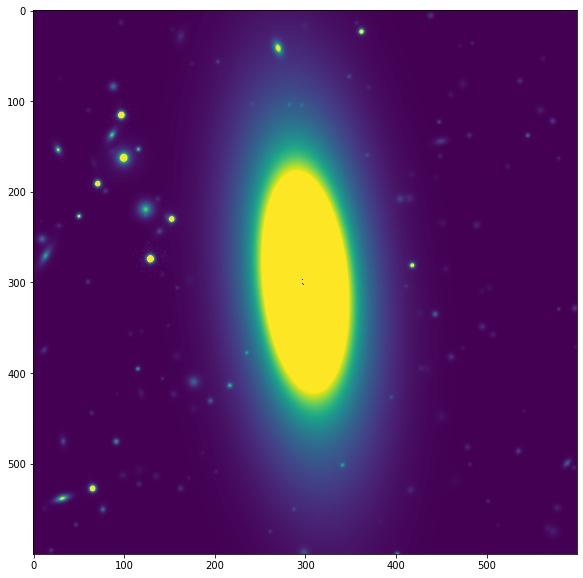

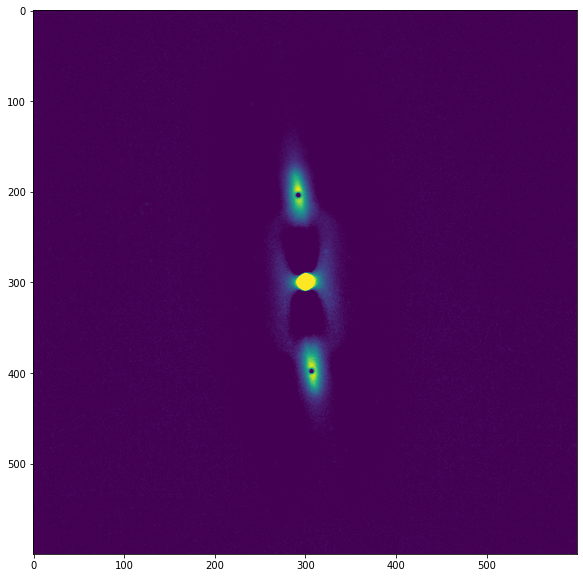

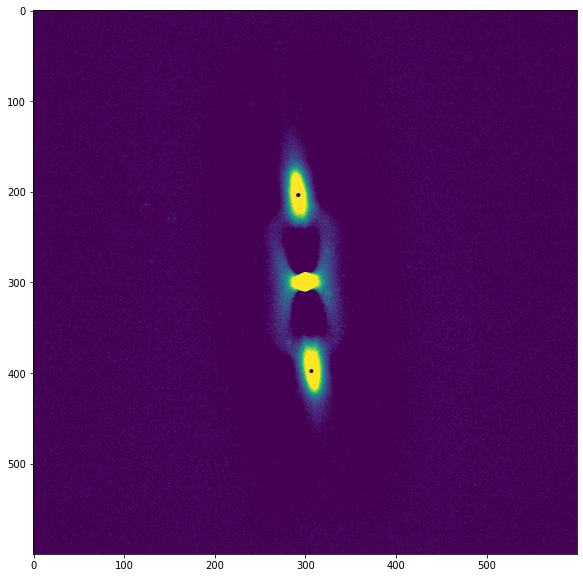

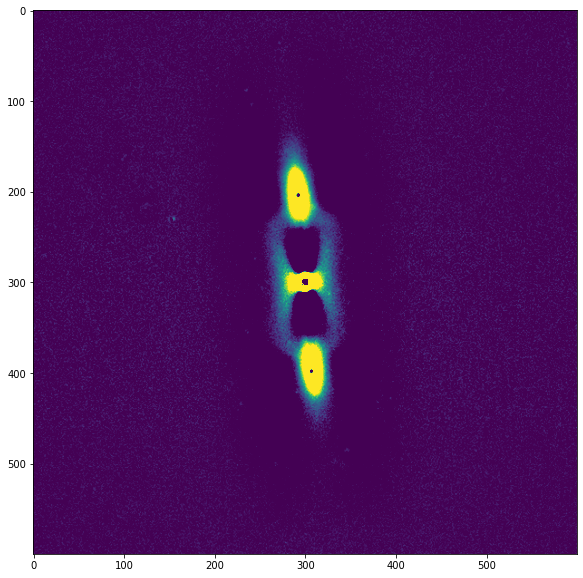

In [263]:
# Загрузка и рисование исходных изображений
if mode=='a':
    size=600
    for name_gal in df_proc_gal[0]:
        ind_gal = getind_gal(name_gal,df_all_gal)
        load_legacy(name_fold=name_fold,name=name_gal, ra=df_all_gal[1][ind_gal],
                    dec=df_all_gal[2][ind_gal], size=size)
        draw(name_fold=name_fold,name_gal=name_gal)

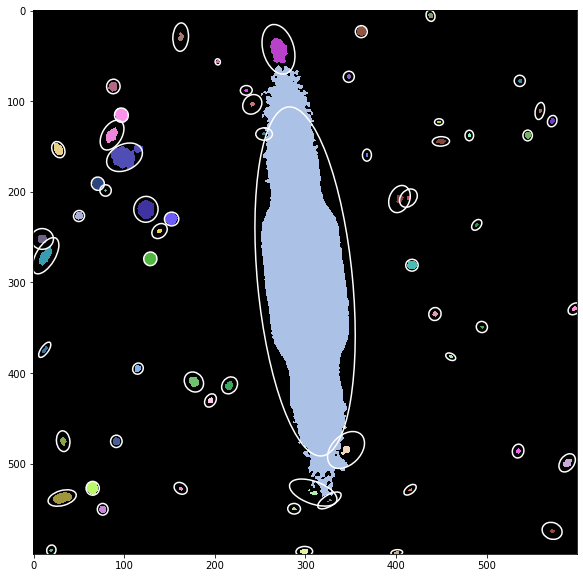

In [268]:
# Получение параметров
if mode=='a':
    angles = []; sizes = []; xlencrops = []; ylencrops = []; xcentroids = []; ycentroids = []
    for name_gal in df_proc_gal[0]:
        tab_params = getparams_ell(name_fold,name_gal,segdeb_npix=200,segdeb_nlev=32,segdeb_contr=0.001)
        newsize,xlencrop,ylencrop,xcentroid,ycentroid = getnew_cropsize(tab_params,sizefac=2.0,xfac=1.25,yfac=2.0)
        angles.append(tab_params['orientation'].value)
        sizes.append(newsize)
        xlencrops.append(xlencrop)
        ylencrops.append(ylencrop)
        xcentroids.append(xcentroid)
        ycentroids.append(ycentroid)

In [269]:
# Как уже было сказано, предполагалась повторная загрузка изображений с новыми размерами, но это слишком долго
# Хотя, вроде, есть такие изображения, которые не влезают в кадр, но с ними лучше индивидуально работать 
#if mode=='a':
#    i = 1
#    for name_gal in df_proc_gal[0]:
#        ind_gal = getind_gal(name_gal,df_all_gal)
#        load_legacy(name_fold=name_fold,name=name_gal, ra=df_all_gal[ind_gal][1],
#                    dec=df_all_gal[ind_gal][2], size=sizes[i-1])
#        draw(name_fold=name_fold,name_gal=name_gal)
#        i += 1

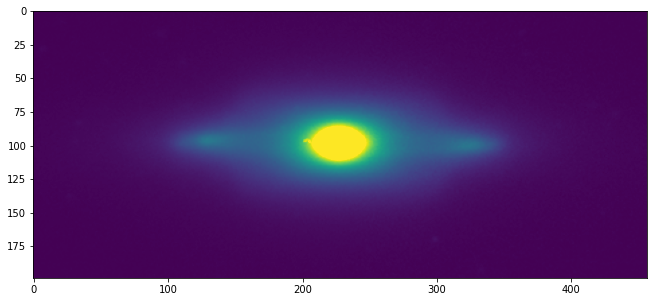

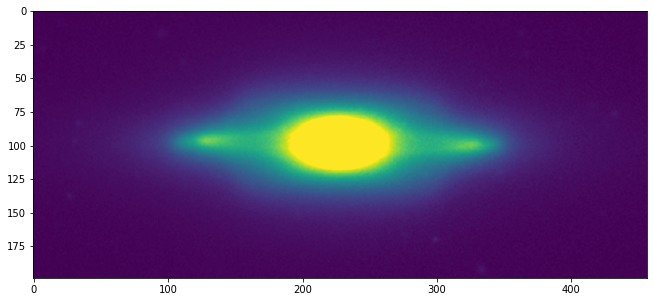

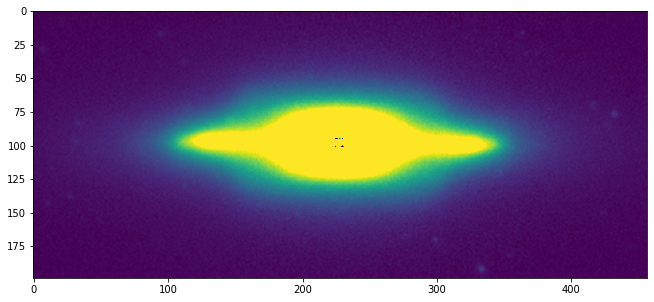

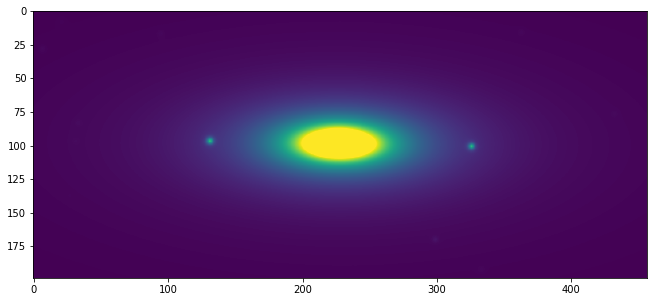

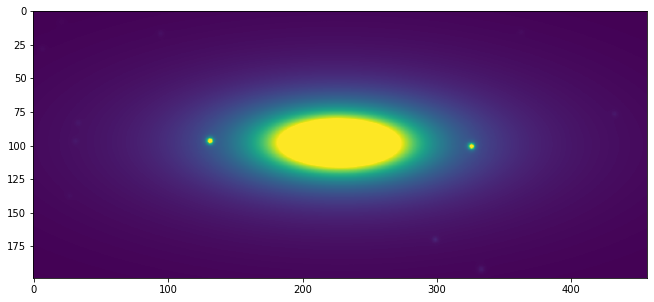

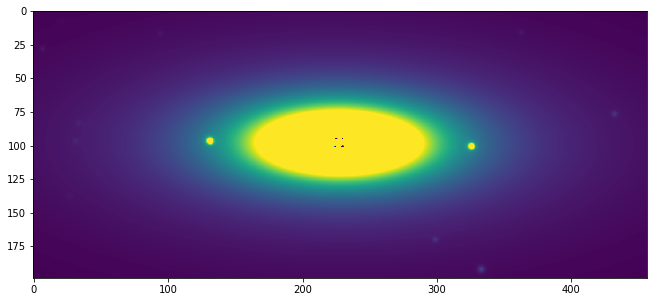

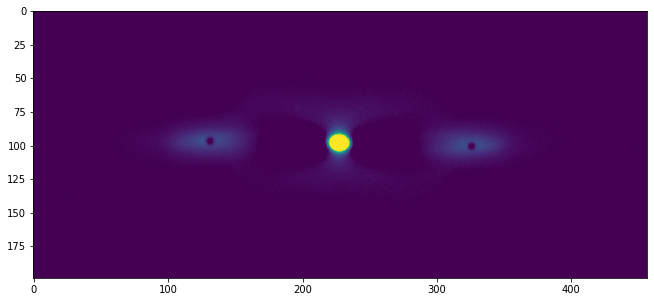

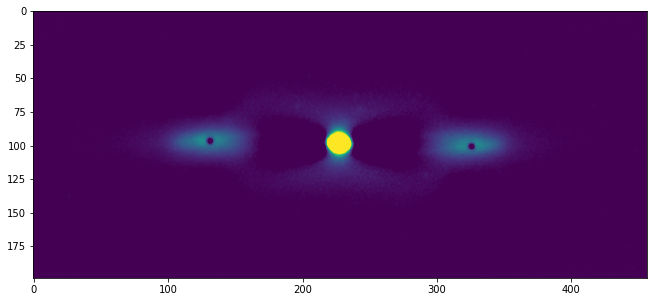

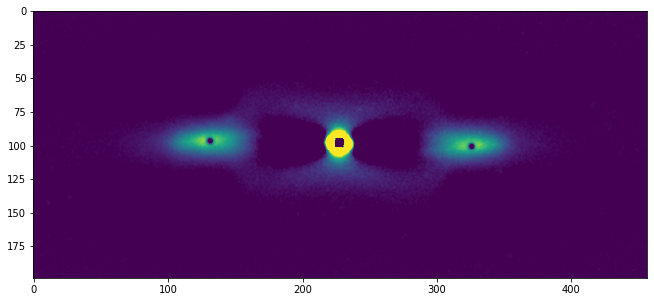

In [270]:
# Поворот и обрезка кадров (здесь могут получатся иногда странные кадры, но это, скорее, из-за больших размеров
# галактики)
if mode=='a':
    i = 0
    for name_gal in df_proc_gal[0]: # вместо sizes[i] используем size, т.к. обрезка кадров только сейчас будет
        rotate_crop_image(name_fold,name_gal,angles[i],size,xlencrops[i],ylencrops[i],xcentroids[i],ycentroids[i]) 
        i += 1

/tmp/ipykernel_2537/3142217518.py:26: RuntimeWarning: invalid value encountered in log2
  ax.imshow(np.log2(img_data_raw), cmap=cm.bone_r, vmin=-6, vmax=-0.5)
/tmp/ipykernel_2537/3142217518.py:27: RuntimeWarning: invalid value encountered in log2
  ax.contour(np.log2(img_data_raw), levels=np.linspace(np.log2(lim1), np.log2(lim2), 11), colors='m',


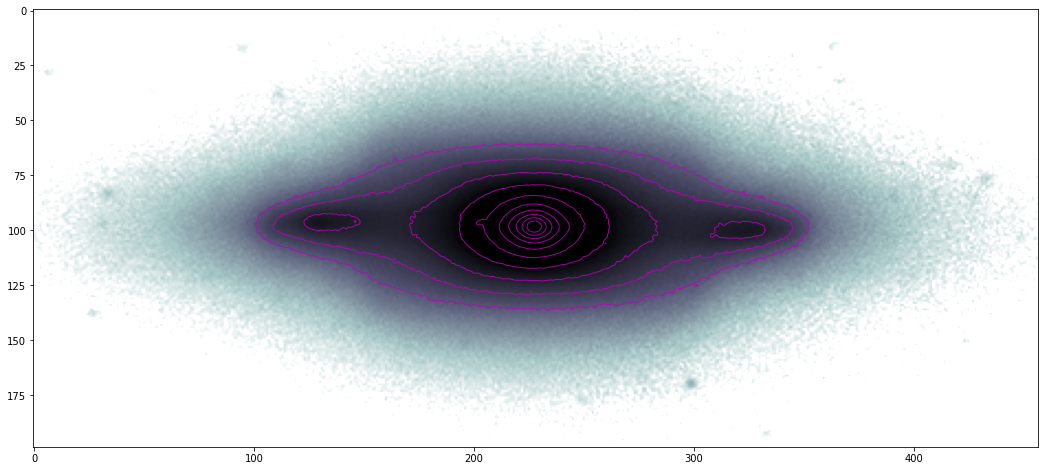

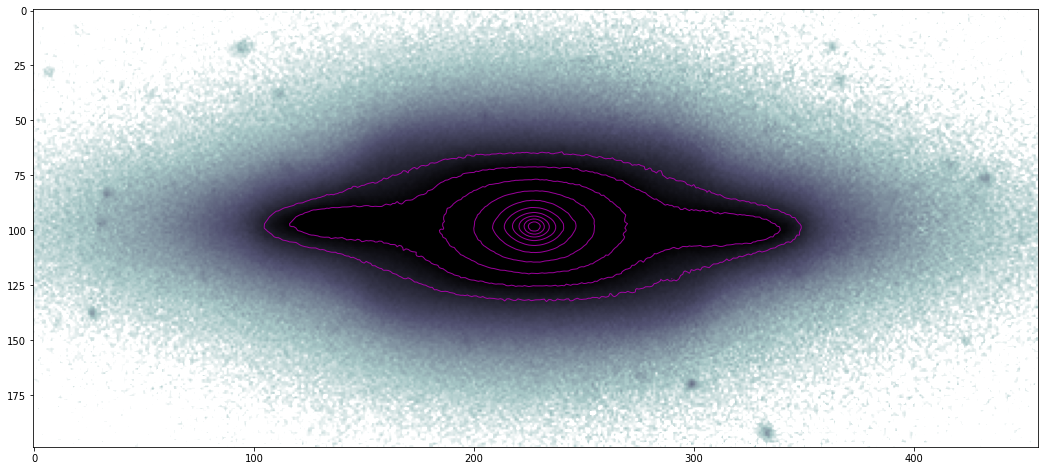

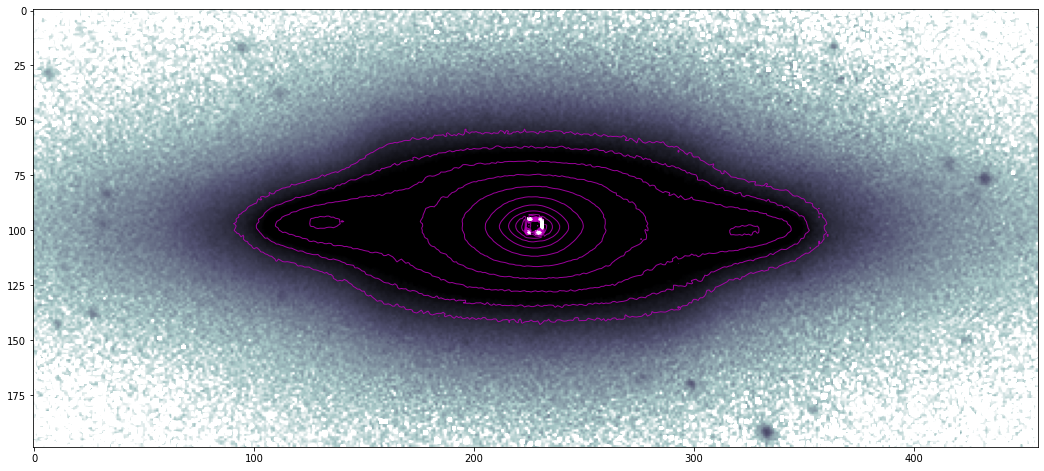

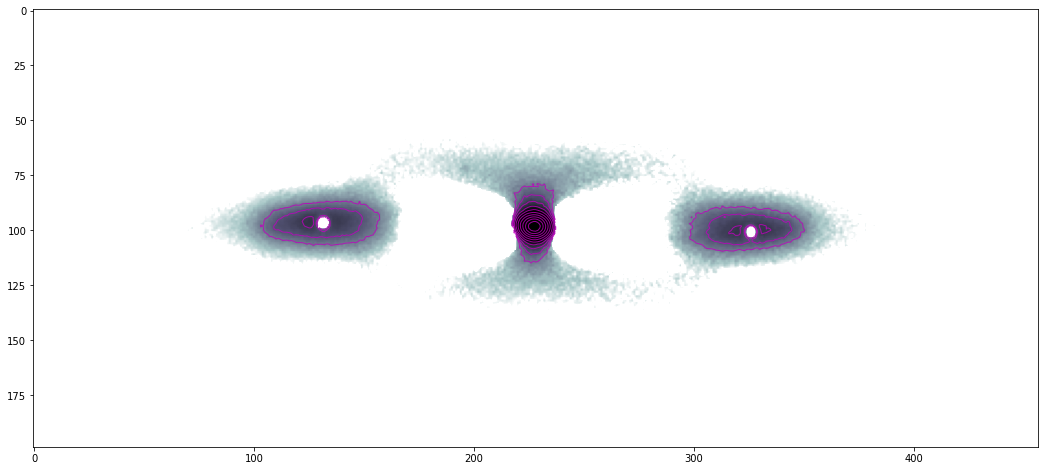

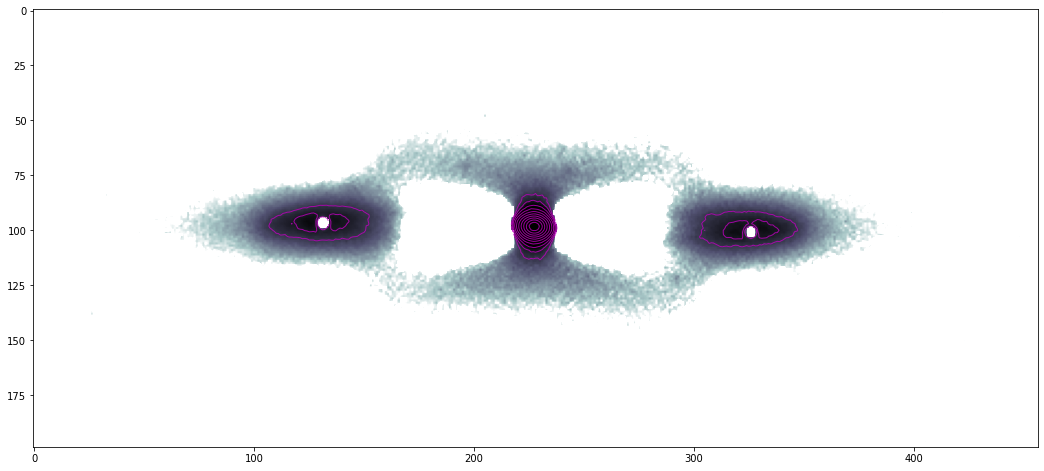

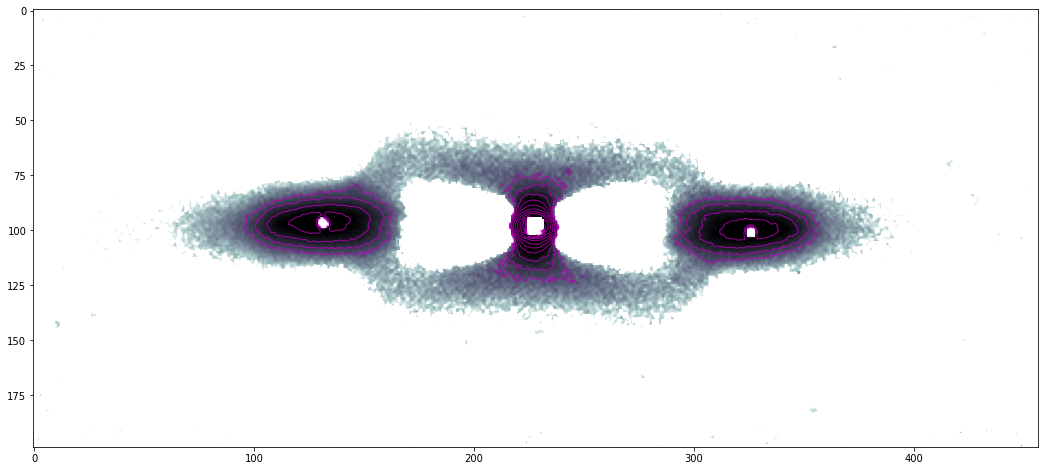

In [271]:
# Изофоты.
if mode=='a':
    for name_gal in df_proc_gal[0]:
        draw_iso(name_fold,name_gal,size) #тоже size вместо sizes[i]

/tmp/ipykernel_2537/2338838115.py:14: RuntimeWarning: invalid value encountered in log10
  data_g = 22.5 - 2.5*np.log10(data)
/tmp/ipykernel_2537/2338838115.py:18: RuntimeWarning: invalid value encountered in log10
  data_r = 22.5 - 2.5*np.log10(data)


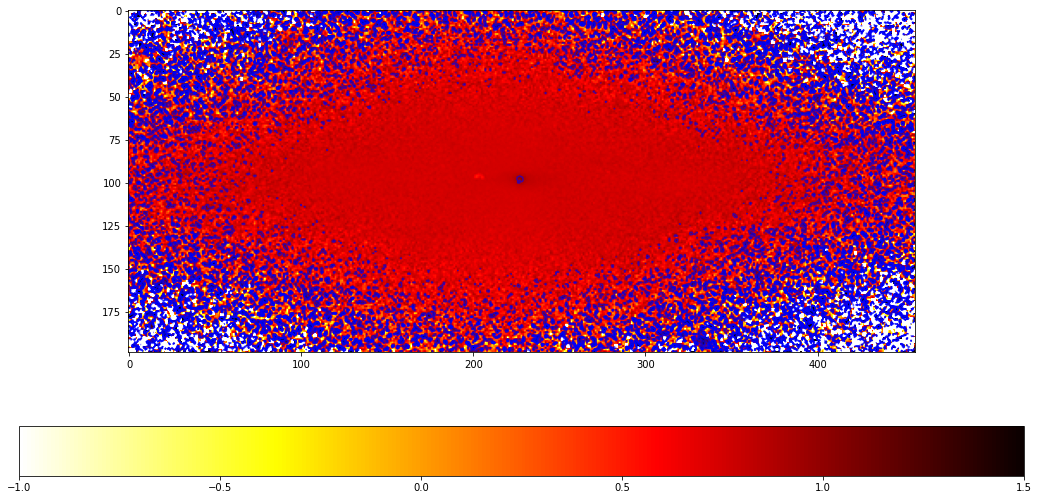

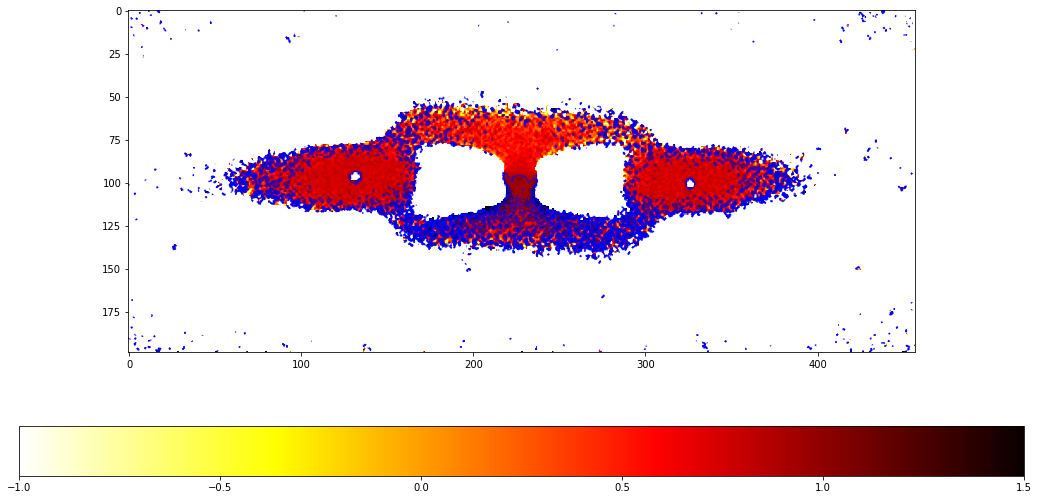

In [272]:
# Показатель цвета
if mode=='a':
    for name_gal in df_proc_gal[0]:
        draw_color(name_fold,name_gal)

# Interactive (manual) mode
----------------------------------------------------------------------------------------

In [131]:
# Выбирается конкретная галактика из конкретного списка     (в принципе, дальше всё то же самое)
if mode=='i':
    name_fold = 'mass_bulge'
    name_gal = 'EON_247.192_39.463'        

In [132]:
if mode=='i':
    size=300 # можно здесь регулировать, можно получать из следующего блока
    ind_gal = getind_gal(name_gal,df_all_gal)
    load_legacy(name_fold=name_fold,name=name_gal, ra=df_all_gal[1][ind_gal],
                    dec=df_all_gal[2][ind_gal], size=size)
    draw(name_fold=name_fold,name_gal=name_gal)

HTTPError: HTTP Error 502: Bad Gateway

In [688]:
if mode=='i':
    tab_params = getparams_ell(name_fold,name_gal,segdeb_npix=200,segdeb_nlev=32,segdeb_contr=0.001)
    newsize,xlencrop,ylencrop = getnew_cropsize(tab_params,sizefac=2.0,xfac=1.25,yfac=2.0)
    angle = tab_params['orientation'].value

In [ ]:
#if mode=='i':
#    ind_gal = getind_gal(name_gal,df_all_gal)
#    load_legacy(name_fold=name_fold,name=name_gal, ra=df_all_gal[1][ind_gal],
#                    dec=df_all_gal[2][ind_gal], size=size)
#    draw(name_fold=name_fold,name_gal=name_gal)

In [653]:
if mode=='i':
    rotate_crop_image(name_fold,name_gal,angle,size,xlencrop,ylencrop)

In [689]:
if mode=='i':
    draw_iso(name_fold,name_gal,size)

In [690]:
if mode=='i':
    draw_color(name_fold,name_gal)